In [ ]:
# @title Data Reading
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multitest import multipletests
import warnings
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
from scipy.stats import gmean
from datetime import datetime


gene_count_path ='/content/drive/MyDrive/MITResearch/IBD_13/gene_count_preprocessed.csv'
metaphlan_path = '/content/drive/MyDrive/MITResearch/IBD_13/metaphlan_preprocessed.csv'

gene_count_df = pd.read_csv(gene_count_path)
metaphlan_df = pd.read_csv(metaphlan_path)

print(gene_count_df.shape)
print(metaphlan_df.shape)

(605, 547)
(479, 1454)


[('TR_2104', 's__Gordonibacter_pamelaeae'), ('TR_2202', 's__Clostridiaceae_bacterium'), ('TR_2107', 's__Dorea_sp_AF36_15AT'), ('TR_2106', 's__Anaeromassilibacillus_sp_An250'), ('TR_2107', 's__GGB3817_SGB5182'), ('TR_2106', 's__Phocaeicola_vulgatus'), ('TR_2104', 's__Blautia_sp_MSK_20_85'), ('TR_2102', 's__GGB9621_SGB15073'), ('TR_2106', 's__Faecalibacterium_SGB15346'), ('TR_2102', 's__Veillonella_parvula'), ('TR_2108', 's__Enterocloster_bolteae'), ('TR_2105', 's__Streptococcus_salivarius'), ('TR_2201', 's__Clostridium_sp_AF20_17LB'), ('TR_2107', 's__Bacteroides_caccae'), ('TR_2101', 's__Blautia_massiliensis'), ('TR_2106', 's__Roseburia_faecis')]


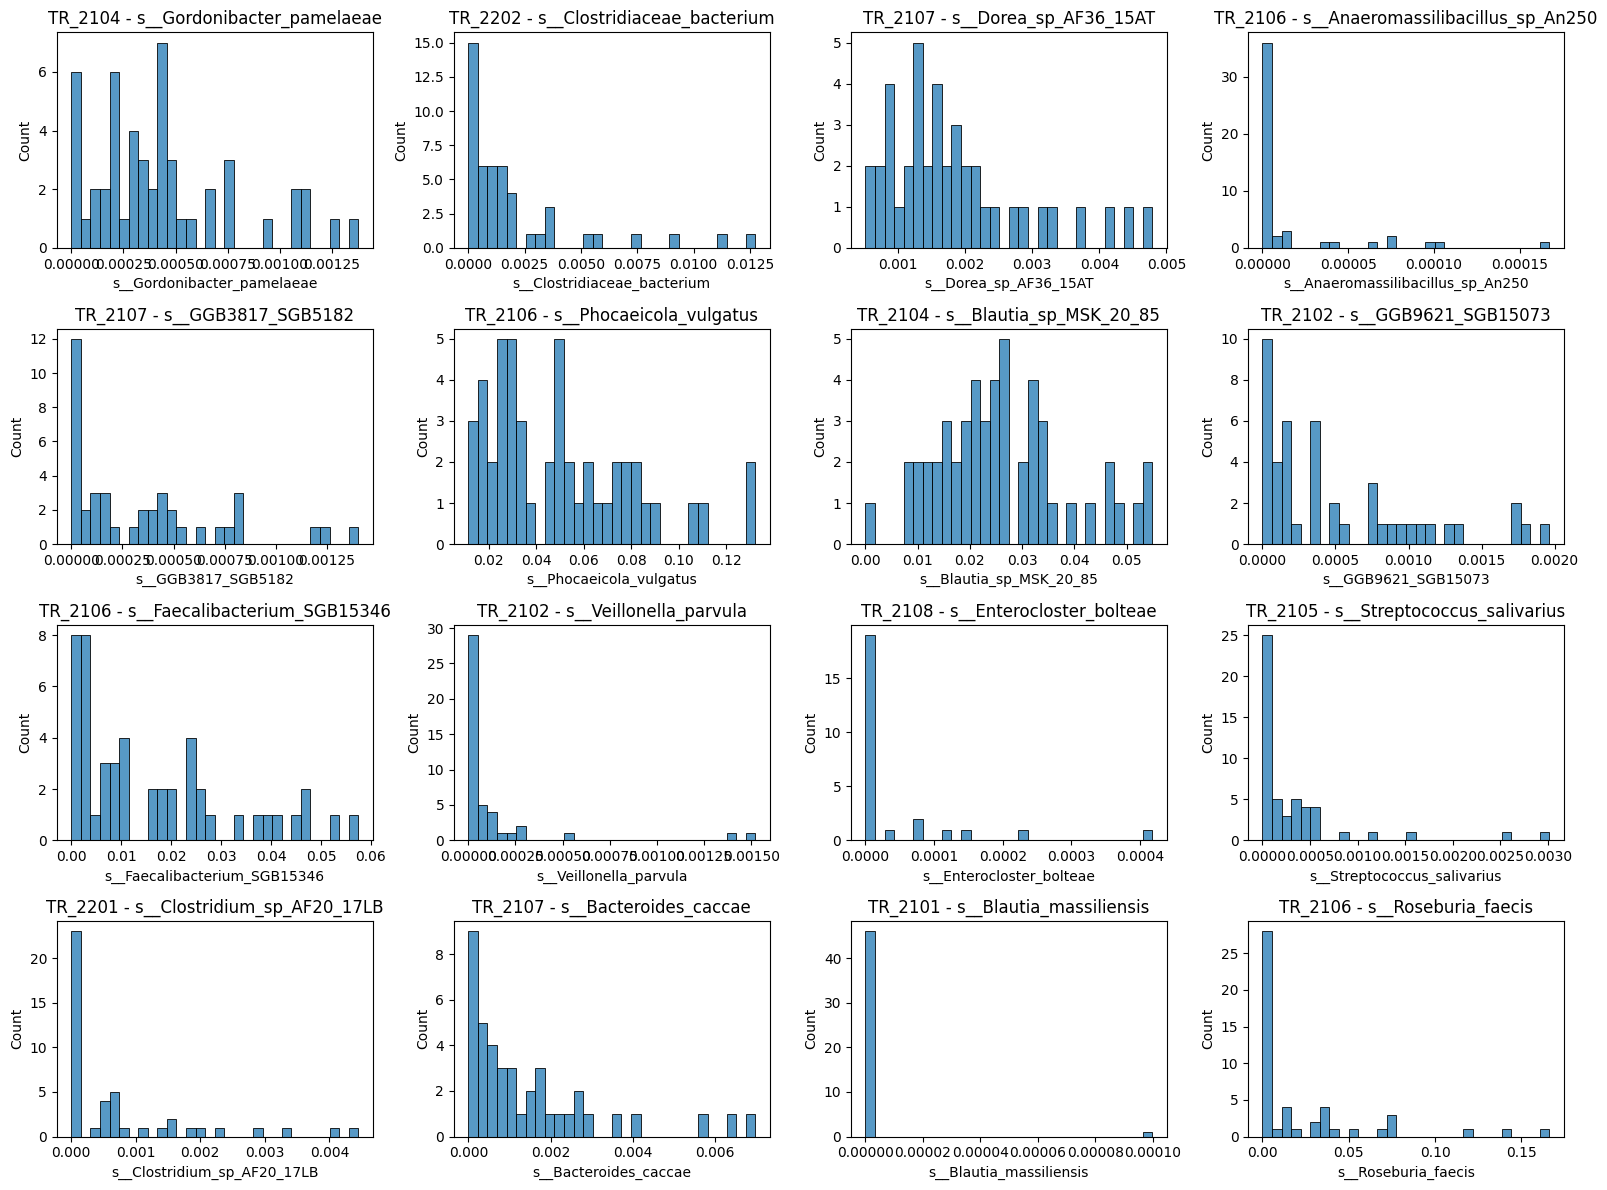

In [ ]:
# @title Plot Microbial Abundance Profiles
combinations = []

# Loop until we have 10 good combinations
while len(combinations) < 16:
    # Randomly select a patient_id and column name
    patient_id = metaphlan_df['patient_id'].sample().values[0]
    column_name = metaphlan_df.columns[np.random.randint(1, len(metaphlan_df.columns))]

    # Check if the values for the selected patient_id and column are not all zeros
    if not all(metaphlan_df[metaphlan_df['patient_id'] == patient_id][column_name] == 0):
        # Add the combination to the list
        combinations.append((patient_id, column_name))

# Print the list of good combinations
print(combinations)

# Define the number of rows and columns for the subplot grid
nrows = 4
ncols = 4

# Create the figure and subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# Iterate through the list of combinations
for i, (patient_id, column_name) in enumerate(combinations):
    # Select the current subplot
    ax = axes.flat[i]

    # Plot the histogram of values
    sns.histplot(data=metaphlan_df[metaphlan_df['patient_id'] == patient_id][column_name], ax=ax, bins= 30)

    # Set the title of the subplot
    ax.set_title(f'{patient_id} - {column_name}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
exclude_columns = ['PatientID_Weeknr', 'patient_id', 'week', 'Flare_status']

In [ ]:
# @title CLR transformation
def clr_transform(df, metadata_columns):
    species_data = df.drop(columns=metadata_columns)
    species_data += 1e-5
    geometric_means = gmean(species_data, axis=1)
    clr_transformed_data = np.log(species_data.divide(geometric_means, axis=0))
    clr_transformed_df = pd.concat([df[metadata_columns], clr_transformed_data], axis=1)
    return clr_transformed_df

metaphlan_df = clr_transform(metaphlan_df, exclude_columns)

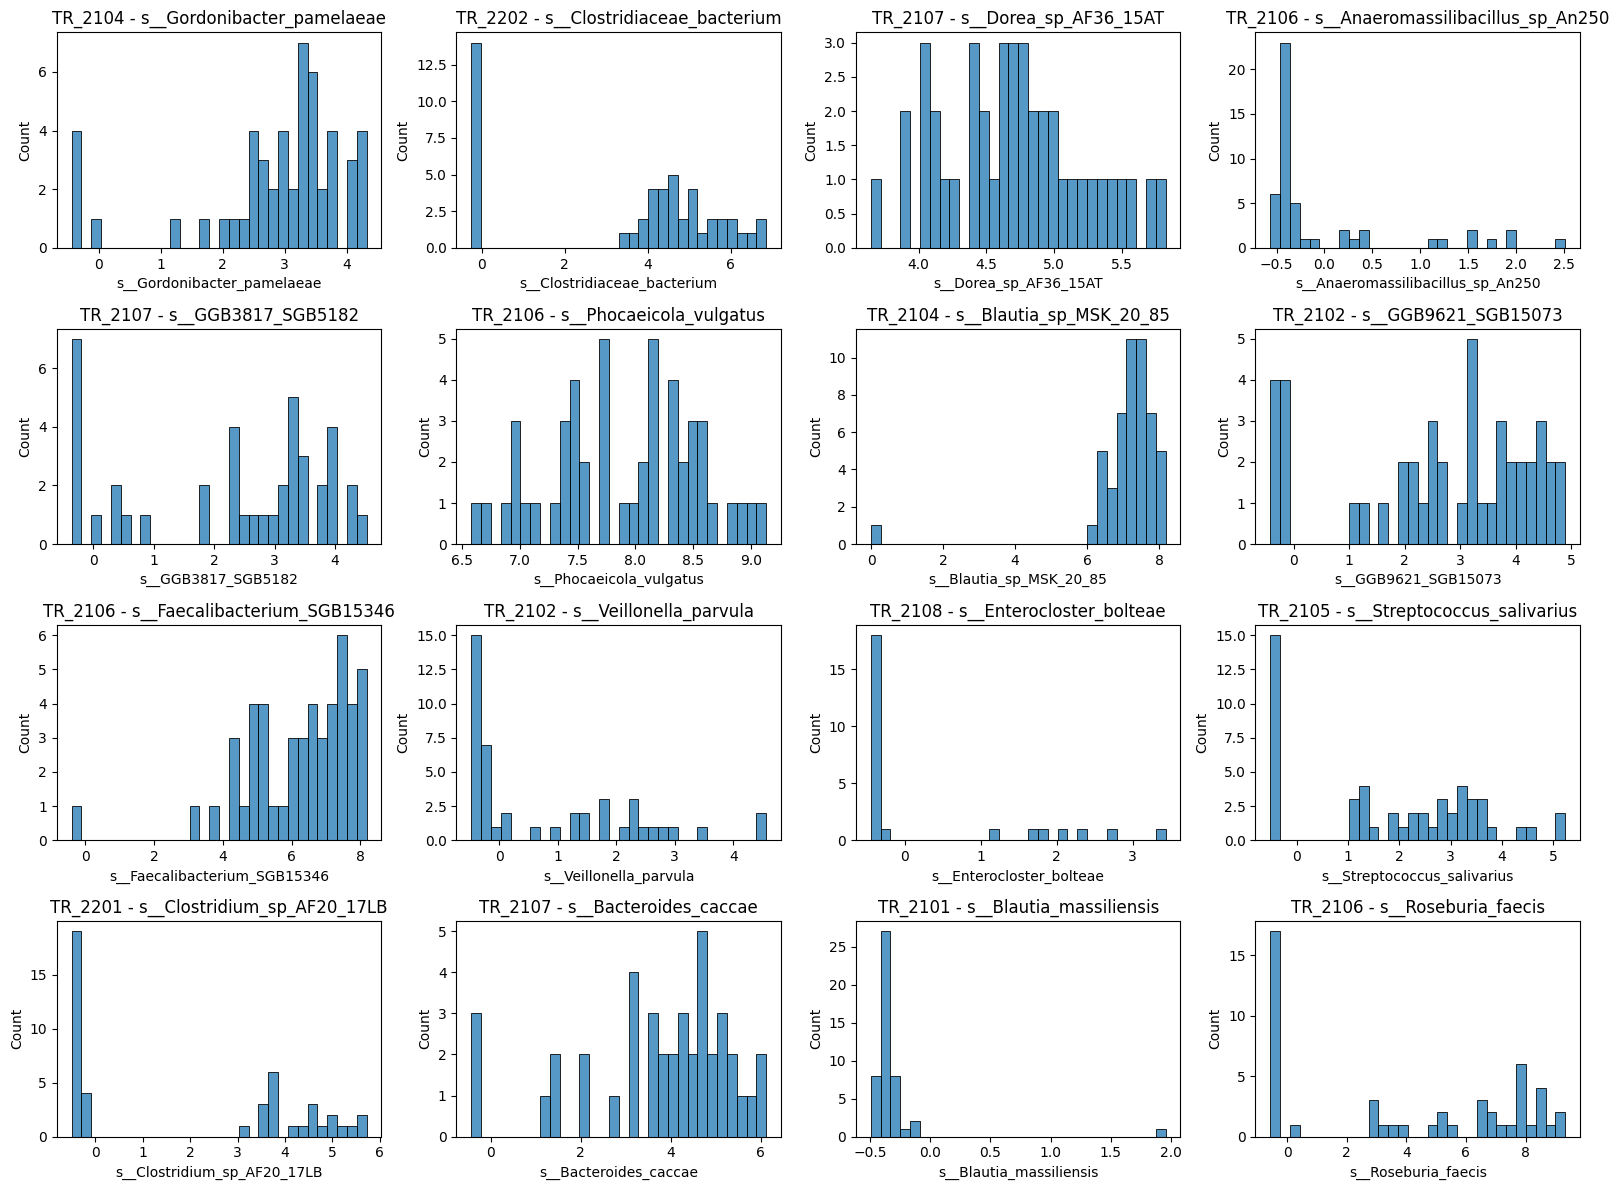

In [ ]:
# @title Plot Microbial Abundance profile after CLR transformation
# Create the figure and subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# Iterate through the list of combinations
for i, (patient_id, column_name) in enumerate(combinations):
    # Select the current subplot
    ax = axes.flat[i]

    # Plot the histogram of values
    sns.histplot(data=metaphlan_df[metaphlan_df['patient_id'] == patient_id][column_name], ax=ax, bins= 30)

    # Set the title of the subplot
    ax.set_title(f'{patient_id} - {column_name}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# @title flag_first_flare_weeks function

def flag_first_flare_weeks(df):
    # Identify the rows where flare starts
    df['is_flare'] = (df['Flare_status'] == 'During_flare') | (df['Flare_status'] == 'During_flare_2')

    # Sort by patient and week to ensure the chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Mark each flare start for each patient
    df['Flare_start'] = (df['is_flare']) & (df['is_flare'] != df['is_flare'].shift(1))

    # Convert boolean to integer (1 for True, 0 for False)
    df['Flare_start'] = df['Flare_start'].astype(int)

    # Drop helper columns if they are no longer needed
    df.drop('is_flare', axis=1, inplace=True)

    return df

In [ ]:
# @title align_flare_start_function
def align_flare_start_week(df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0):
    """
    Adjusts the week numbers for each patient in the dataframe such that the first occurrence
    of Flare_start=1 (that is not the first sample for the patient) occurs in the same target week for all patients who have a flare start.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    flare_column (str): Column name indicating the flare start.
    week_column (str): Column name indicating the week number.
    patient_column (str): Column name indicating the patient ID.
    target_week (int): The week number to which the first flare start should be aligned.

    Returns:
    pd.DataFrame: Modified DataFrame with adjusted week numbers.
    """
    df = df.copy()
    adjusted_dfs = []

    # Add a column indicating if the patient had a flare or not
    df['had_flare'] = df.groupby(patient_column)[flare_column].transform('max')

    for patient in df[patient_column].unique():
        patient_data = df[df[patient_column] == patient].copy()
        first_week = patient_data[week_column].min()

        if patient_data['had_flare'].iloc[0] == 1:
            # Identify flare weeks and remove the first week if it's a flare
            flare_weeks = patient_data[patient_data[flare_column] == 1][week_column]
            flare_weeks = flare_weeks[flare_weeks > first_week]  # ignore flare at the first recorded week

            if not flare_weeks.empty:
                flare_week = flare_weeks.min()  # first flare that's not at the first week
                shift = target_week - flare_week
                patient_data[week_column] += shift

        adjusted_dfs.append(patient_data)

    aligned_df = pd.concat(adjusted_dfs, ignore_index=True)

    # Normalize to ensure there are no negative weeks
    min_week = aligned_df[week_column].min()
    if min_week < 0:
       aligned_df.loc[aligned_df['had_flare'] == 1, week_column] -= min_week

    # Remove the temporary 'had_flare' column before returning
    aligned_df.drop('had_flare', axis=1, inplace=True)

    return aligned_df

In [ ]:
# @title normalize_to_housekeeping_genes function
def normalize_to_housekeeping_genes(df, housekeeping_genes, exclude_columns):
    # Convert data in DataFrame to numeric types, except for excluded columns
    for column in df.columns:
        if column not in exclude_columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')

    # Find columns that start with any of the housekeeping gene symbols and are not in the excluded list
    hk_gene_cols = [col for col in df.columns
                    if any(col.startswith(hk + '_') for hk in housekeeping_genes) and col not in exclude_columns]

    # Selecting housekeeping genes data
    hk_genes_data = df[hk_gene_cols]

    # Calculate the geometric mean of the housekeeping genes for each sample
    # Adding a small value (e.g., 1e-9) to avoid taking log(0)
    geometric_mean_hk = np.exp(np.log(hk_genes_data + 1e-9).mean(axis=1))

    # Normalize the entire gene count matrix by the geometric mean of the housekeeping genes
    # Apply normalization only to numeric columns
    for column in df.columns:
        if column not in exclude_columns:
            df[column] = df[column].div(geometric_mean_hk, axis=0)

    return df

In [ ]:
import pandas as pd

def calculate_dtf(data):
    # Ensure data is sorted by patient_id and week for correct processing
    data = data.sort_values(['patient_id', 'week'])

    # Create the dtf column initialized with zeros
    data['dtf'] = 0.0

    # Process each patient's data
    for patient_id, group in data.groupby('patient_id'):
        # Reverse the data to look forward from each week
        reversed_group = group.iloc[::-1]
        weeks_until_flare = 0
        found_flare = False

        # Iterate over each row in reversed order
        for index, row in reversed_group.iterrows():
            if row['flare_start'] == 1:
                weeks_until_flare = 0  # Reset counter on flare
                found_flare = True
            else:
                weeks_until_flare += 1  # Increment weeks until next flare

            # Compute dtf if a flare has been found
            if found_flare:
                data.at[index, 'dtf'] = 1 / weeks_until_flare if weeks_until_flare != 0 else 0
            else:
                data.at[index, 'dtf'] = 0

    return data

# Example usage
data = pd.DataFrame({
    'patient_id': [1, 1, 1, 1, 2, 2, 2, 2],
    'week': [1, 2, 3, 4, 1, 2, 3, 4],
    'flare_start': [0, 0, 1, 0, 0, 0, 0, 1]
})

result = calculate_dtf(data)
print(result)


In [ ]:
# @title plot_species_abundance_over_time_2 function
def plot_species_abundance_over_time_2(df, cols_to_plot, title, type_):
    """
    Plots the abundance over time for the specified species for all patients in the dataframe,
    with separate plots for patients with and without a flare start, all in a single figure with subplots.

    Args:
    df (pd.DataFrame): DataFrame containing microbial abundance data.
    cols_to_plot (list): List of species names to plot.
    title (str): Title for the plots and y-axis label.
    type_ (str): Label for the plot legend.
    """
    if not cols_to_plot:
        raise ValueError("cols_to_plot must be provided when selection_mode is 'user'")

    num_species = len(cols_to_plot)
    cols = 2  # Number of columns for subplots (one for with flare, one for without)
    rows = num_species  # Each species will occupy one row with two subplots

    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # Adjust figsize as needed

    # If only one species, axs might not be a 2D array, ensure it is
    if num_species == 1:
        axs = [axs]

    # Determine patients where the first recorded week is a flare start
    df['first_week'] = df.groupby('patient_id')['week'].transform('min')  # Find first week for each patient
    first_flare_patients = df[(df['Flare_start'] == 1) & (df['week'] == df['first_week'])]['patient_id'].unique()
    patients_with_flare = df[(df['Flare_start'] == 1) & (~df['patient_id'].isin(first_flare_patients))]['patient_id'].unique()
    patients_without_flare = df[~df['patient_id'].isin(patients_with_flare)]['patient_id'].unique()


    for i, species in enumerate(cols_to_plot):
        # Plot for patients with flare
        ax = axs[i][0]

        for patient in patients_with_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        # Annotate flare start changes
        flare_changes = df[(df["Flare_start"] == 1)&(df['patient_id'].isin(patients_with_flare ))][['week', 'Flare_start']].drop_duplicates()
        for _, (week, status) in flare_changes.iterrows():
            ax.axvline(x=week, color='grey', linestyle='--')
            ax.text(week, ax.get_ylim()[1], 'Flare_start', verticalalignment='top', fontsize=8)

        ax.set_title(f'{title} ({species}) Over Time for Patients with Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

        # Plot for patients without flare
        ax = axs[i][1]
        for patient in patients_without_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        ax.set_title(f'{title} ({species}) Over Time for Patients without Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
# @title random forest based on first differences

def calculate_first_differences(df, cols_to_drop):
    """
    Calculates the first differences for each gene and species column, considering missing weeks and dummy patient_id columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing dummy 'patient_id' columns, 'week', 'Flare_status', 'RBF', and gene/species columns.

    Returns:
    pd.DataFrame: A new dataframe with the first differences and a week column.
    """
    # Identify patient_id columns
    patient_id_columns = [col for col in df.columns if col.startswith('patient_id')]

    # Identify gene/species columns
    exclude_columns = patient_id_columns + cols_to_drop
    gene_species_columns = df.columns.difference(exclude_columns)

    # Sort the dataframe by patient_id columns and week
    df = df.sort_values(by=patient_id_columns + ['week'])

    # Group by patient_id columns and calculate first differences
    df_diff = df.groupby(patient_id_columns).apply(lambda group: group[gene_species_columns].diff()).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)

    # Correct the week column in the first differences dataset
    df_diff['week'] = df['week']

    # Add patient_id columns back to the first differences dataset
    for col in patient_id_columns:
        df_diff[col] = df[col]

    # Add 'Flare_status' and 'RBF' columns back to the first differences dataset
    df_diff['Flare_status'] = df['Flare_status']
    df_diff['RBF'] = df['RBF']

    # Remove the first week for each patient as we cannot compute the difference for the first week
    df_diff.dropna(inplace=True, subset=gene_species_columns)

    # Reorder columns to match the original structure
    df_diff = df_diff[patient_id_columns + ['week'] + gene_species_columns.tolist() + ['Flare_status', 'RBF']]

    return df_diff

In [ ]:
print(gene_count_df.shape)
print(metaphlan_df.shape)

(605, 547)
(479, 1454)


In [ ]:
# @title Adding a Flare_start column
metaphlan_df = flag_first_flare_weeks(metaphlan_df)
gene_count_df = flag_first_flare_weeks(gene_count_df)

In [ ]:
# @title normalize to housekeeping genes
house_keeping_genes = ["ACTB", "ATP5F1", "B2M", "GAPDH", "GUSB",
                       "HPRT", "PGK1", "PPIA", "RPS18", "TBP",
                       "TFRC", "YWHAZ"]

exclude_columns += [ 'Flare_start']

# Normalizing the DataFrame
gene_count_df = normalize_to_housekeeping_genes(gene_count_df, house_keeping_genes, exclude_columns)

In [ ]:
gc = align_flare_start_week(gene_count_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)
mt = align_flare_start_week(metaphlan_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)

In [ ]:
week_stats = gene_count_df.groupby('patient_id')['week'].agg(['min', 'max'])
print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2104       1   52
TR_2105       1   52
TR_2106       0   52
TR_2107       0   52
TR_2108       0   52
TR_2201       1   52
TR_2202       1   50
TR_2203       0   52
TR_2204       0   52
TR_2205       1   50


In [ ]:
week_stats = metaphlan_df.groupby('patient_id')['week'].agg(['min', 'max'])
print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2104       1   52
TR_2105       1   52
TR_2106       0   52
TR_2107       0   42
TR_2108      16   52
TR_2201       1   52
TR_2202       1   50
TR_2203       0   22
TR_2205      39   50


# Classification

In [ ]:
cols_to_drop = [ 'week', 'Flare_start','Flare_status', 'RBF','PatientID_Weeknr']

In [ ]:
# @title Processing function
def processing(df, samples_before_flare, include_post_flare, include_during_flare=False, strict=False ):
  #Assign RBF flags with x samples before flare as default or any other number you wish
  print(f'samples before flare: {samples_before_flare}')
  df = assign_rbf(df, samples_before_flare=samples_before_flare, strict=strict)

  if not include_post_flare :
    data = df[(df["Flare_status"] != "Post_flare") &
               (df["Flare_status"] != "During_flare") &
               (df["Flare_status"] != "During_flare_2")]
  elif not include_during_flare :
    data = df[ (df["Flare_status"] != "During_flare") &
              (df["Flare_status"] != "During_flare_2")]

  else :
    data = df

  original_columns = set(data.columns)
  data = pd.get_dummies(data, columns=['patient_id'], drop_first=True)
  patient_cols = list(set(data.columns) - original_columns)

  print(data["RBF"].value_counts())
  return data, patient_cols

In [ ]:
# @title hyperparameter tuning function

def hyperparameter_tuning(data, cols_to_drop, patient_cols):
  # Drop specified columns and separate features and target
  X = data.drop(cols_to_drop + patient_cols, axis=1)
  y = data['RBF']

  # Define the parameter grid
  # param_grid = {
  #     'n_estimators': [100, 200, 300],  # Number of trees in the forest
  #     'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
  #     'max_depth': [None, 10, 20, 30],   # Maximum number of levels in tree
  #     'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
  #     'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
  # }

  param_grid = {
      'n_estimators': [12, 25, 100],  # Number of trees in the forest
      'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
      'max_depth': [None, 10, 30],   # Maximum number of levels in tree
      'min_samples_split': [2,10, 15],   # Minimum number of samples required to split a node
      'min_samples_leaf': [1, 3]      # Minimum number of samples required at each leaf node
  }

  # Initialize the Random Forest classifier
  clf = RandomForestClassifier(random_state=421)

  # Define scoring strategy
  scoring = 'recall'

  cv = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=5)

  # Fit the grid search to the data
  grid_search.fit(X, y)

  # Print the best parameters and best score
  print("Best parameters:", grid_search.best_params_)
  print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

  # Use the best estimator to make predictions
  best_clf = grid_search.best_estimator_

  importances = best_clf.feature_importances_
  # Get the index of importances from highest importance to lowest
  sorted_index = np.argsort(importances)[::-1]
  print("Feature ranking:")

  for idx in sorted_index:
    if importances[idx] > 0.01:
      print(f"{X.columns[idx]}: ({importances[idx]})")

  return grid_search

In [ ]:
# @title model evaluation
def model_evaluation(data, grid_search, cols_to_drop, patient_cols, settings, type, data_type='validation',  n_splits=10, result_file='/content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_3.csv'):
    """
    Evaluate the model using either training data or unseen data, computing a total confusion matrix from all splits.

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    grid_search: The GridSearchCV object containing the trained model.
    cols_to_drop (list of str): The list of columns to drop.
    patient_cols (list of str): The list of dummy patient_id columns.
    data_type (str): The type of data to evaluate ('training' or 'validation'). Default is 'validation'.
    n_splits (int): Number of splits for cross-validation. Default is 10.

    Returns:
    None
    """
    # Data preparation
    X = data.drop(cols_to_drop + patient_cols, axis=1)
    y = data['RBF']

    # Best model from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Check if the 30th column starts with 's__'
    column_type = "Microbial Abundances" if data.columns[29].startswith('s__') else "Gene Expression"

    if data_type == 'validation':
        # Initialize the total confusion matrix
        total_confusion_matrix = None

        # Conduct the stratified cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_index, test_index in tqdm(skf.split(X, y), total=n_splits, desc='Cross-validation'):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model
            best_clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = best_clf.predict(X_test)

            # Compute confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred)

            # Sum up confusion matrices
            if total_confusion_matrix is None:
                total_confusion_matrix = cm
            else:
                total_confusion_matrix += cm

        # Print total confusion matrix from all folds
        print("\n Total Confusion Matrix from all folds:")
        print(total_confusion_matrix)

        # Calculate recall from the total confusion matrix
        TP = total_confusion_matrix[1, 1]  # True Positives
        FN = total_confusion_matrix[1, 0]  # False Negatives
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0

        # Save the result to a CSV file
        result_data = {
        'Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Data_Type': data_type,
        'Confusion_Matrix': str(total_confusion_matrix.tolist()),
        'Parameters': str(grid_search.best_params_),
        'nsplits' : n_splits,
        'settings' : settings,
        'data': column_type,
        'type': type,
        'recall': recall
        }

        if not os.path.isfile(result_file):
            df = pd.DataFrame([result_data])
            df.to_csv(result_file, index=False)
        else:
            new_row = pd.DataFrame([result_data])
            df = pd.read_csv(result_file)
            df = pd.concat([df, new_row], ignore_index=True)
            df.to_csv(result_file, index=False)

        print("Results saved to:", result_file)

    elif data_type == 'training':
        # Fit the model
        best_clf.fit(X, y)

        # Predict on the training set
        y_pred = best_clf.predict(X)

        # Compute confusion matrix for the training set
        cm = confusion_matrix(y, y_pred)

        # Print the confusion matrix
        print("Training Set Confusion Matrix:")
        print(cm)

    else:
        raise ValueError("data_type must be 'training' or 'validation'")

In [ ]:
# @title Settings
samples_before_flare = 8
include_post_flare = False
strict= False
Normalize_to_Housekeeping = True

In [ ]:
# @title Microbial abundance modeling
settings= {'samples_before_flare': samples_before_flare, 'UCCD': 'not used', 'include_post_flare': include_post_flare, 'strict':strict, 'Normalize_to_Housekeeping' : Normalize_to_Housekeeping}
metaphlan, patient_cols  = processing(metaphlan_df, samples_before_flare=samples_before_flare, include_post_flare=include_post_flare, strict=strict)

grid_search = hyperparameter_tuning(metaphlan, cols_to_drop, patient_cols)

print("Best parameters:", grid_search.best_params_)
model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, settings,'raw', data_type='training', n_splits=10)
model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, settings, 'raw', data_type='validation', n_splits=10)

samples before flare: 8
RBF
0    321
1     59
Name: count, dtype: int64
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 12}
Best cross-validation F1 score: 0.37
Feature ranking:
s__Eubacterium_SGB6276: (0.05102425345800566)
s__Peptostreptococcus_anaerobius: (0.049639490136754616)
s__GGB4588_SGB6347: (0.03430762873427528)
s__Roseburia_hominis: (0.03240730919041157)
s__Lachnospiraceae_bacterium_Marseille_Q4251: (0.024988578766686434)
s__Anaerococcus_obesiensis: (0.024664584907026537)
s__Blautia_wexlerae: (0.021269975815182997)
s__Holdemanella_porci: (0.021165843060362)
s__Murimonas_intestini: (0.020943195899385245)
s__GGB9621_SGB15073: (0.02039170617595617)
s__GGB3817_SGB5182: (0.019892505653062616)
s__Barnesiella_sp_An22: (0.019812737738655665)
s__GGB34797_SGB14322: (0.018518316267799404)
s__GGB3640_SGB4937: (0.01782836968842534)
s__Lacticaseibacillus_paracasei: (0.017796160024101792)
s__Blautia_hydrogenotrophica: (0.01459610433050397)
s__Bifidobacterium_pullorum: (0.01384564578307

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  10%|█         | 1/10 [00:00<00:01,  6.81it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:01,  7.17it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has be


 Total Confusion Matrix from all folds:
[[310  11]
 [ 32  27]]
Results saved to: /content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_3.csv


In [ ]:
# @title Gene Expression modeling
gene_count, patient_cols = processing(gene_count_df, samples_before_flare=samples_before_flare, include_post_flare=include_post_flare)

grid_search = hyperparameter_tuning(gene_count, cols_to_drop, patient_cols)

samples before flare: 8
RBF
0    389
1     70
Name: count, dtype: int64
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 12}
Best cross-validation F1 score: 0.21
Feature ranking:
ABCB1_ENSG00000085563_ENST00000622132: (0.03363467061345663)
CDKN2A_ENSG00000147889_ENST00000304494: (0.024920708114944765)
PDCD1_ENSG00000188389_ENST00000334409: (0.022714770860303542)
IL27_ENSG00000197272_ENST00000356897: (0.021720431060772327)
MPL_ENSG00000117400_ENST00000372470: (0.02146608398132203)
CCL22_ENSG00000102962_ENST00000219235: (0.021211082036970013)
IFNA1_ENSG00000197919_ENST00000276927: (0.02057036055971547)
TNFRSF18_ENSG00000186891_ENST00000379268: (0.02009800982864196)
PDGFC_ENSG00000145431_ENST00000502773: (0.018482231181492115)
MUC2_ENSG00000198788_ENST00000675028: (0.01650271702070848)
IL17A_ENSG00000112115_ENST00000648244: (0.01642563031143497)
FUT3

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 12}


In [ ]:
model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols, settings, 'raw', data_type='training', n_splits=10)

Training Set Confusion Matrix:
[[389   0]
 [ 26  44]]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols,  settings, 'raw',  data_type='validation', n_splits=10)

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:00, 14.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas


 Total Confusion Matrix from all folds:
[[385   4]
 [ 51  19]]
Results saved to: /content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_3.csv


don't use during flare and post flare samples
add patient id as a feature
ajouter les metadata dans le modele





In [ ]:
cols_to_drop =  [ 'week', 'Flare_status', 'RBF']

In [ ]:
metaphlan_, patient_cols  = processing(metaphlan_df, samples_before_flare=samples_before_flare, include_post_flare=True, include_during_flare=True, strict=strict)
fd_metaphlan_df = calculate_first_differences(metaphlan_, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'])

fd_metaphlan_df= fd_metaphlan_df[ fd_metaphlan_df["Flare_status"] != "During_flare" ]

if not include_post_flare :
  fd_metaphlan_df= fd_metaphlan_df[ fd_metaphlan_df["Flare_status"] != "Post_flare" ]


grid_search = hyperparameter_tuning(fd_metaphlan_df,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

print("Best parameters:", grid_search.best_params_)
model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='training', n_splits=10)
model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='validation', n_splits=10)

samples before flare: 8
RBF
0    418
1     61
Name: count, dtype: int64
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 12}
Best cross-validation F1 score: 0.23
Feature ranking:
s__Peptostreptococcus_anaerobius: (0.030595821535364044)
s__GGB32387_SGB47381: (0.030394178382026835)
s__GGB45597_SGB72777: (0.028563141387238245)
s__Barnesiella_sp_An22: (0.02689701925852182)
s__Murimonas_intestini: (0.02247055230594815)
s__Lachnoclostridium_edouardi: (0.02027023928225112)
s__GGB3571_SGB4778: (0.019788469679208654)
s__Massilistercora_timonensis: (0.017300686457576275)
s__Methylobacterium_SGB15164: (0.016141831354182175)
s__Intestinimonas_SGB15130: (0.01571499321368854)
s__GGB9623_SGB15076: (0.01544573759881535)
s__Coprococcus_catus: (0.014631384884164026)
s__GGB3817_SGB5182: (0.014426518788628412)
s__GGB9642_SGB15119: (0.01423651543885919)
s__Mediterraneibacter_butyricigenes: (0.012673712137243033)
s__Peptostreptococcus_stomatis: (0.012430613524521099)
s__Anaerotignum_lactatifermentans: (

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  10%|█         | 1/10 [00:00<00:01,  5.89it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:01,  6.13it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has be


 Total Confusion Matrix from all folds:
[[306   4]
 [ 47  12]]
Results saved to: /content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_3.csv


In [ ]:
gene_count_, patient_cols  = processing(gene_count_df, samples_before_flare=samples_before_flare, include_post_flare=True, include_during_flare=True, strict=strict)
fd_gene_count_df = calculate_first_differences(gene_count_, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'])

fd_gene_count_df= fd_gene_count_df[ fd_gene_count_df["Flare_status"] != "During_flare" ]

if not include_post_flare :
  fd_metaphlan_df= fd_metaphlan_df[ fd_metaphlan_df["Flare_status"] != "Post_flare" ]


grid_search = hyperparameter_tuning(fd_gene_count_df,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

print("Best parameters:", grid_search.best_params_)
model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='training', n_splits=10)
model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='validation', n_splits=10)

samples before flare: 8
RBF
0    532
1     73
Name: count, dtype: int64
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 12}
Best cross-validation F1 score: 0.03
Feature ranking:
CDKAL1_ENSG00000145996_ENST00000274695: (0.03305938304484585)
IL2RA_ENSG00000134460_ENST00000379959: (0.02781654245176693)
IL11_ENSG00000095752_ENST00000264563: (0.026782266650721625)
CD40LG_ENSG00000102245_ENST00000370629: (0.02528641163980645)
IL21_ENSG00000138684_ENST00000648588: (0.02277847726787317)
TNFRSF13C_ENSG00000159958_ENST00000291232: (0.020914125433852255)
TNFRSF13B_ENSG00000240505_ENST00000261652: (0.020850783119454385)
INS_ENSG00000254647_ENST00000397262: (0.01869112414535418)
CCR5_ENSG00000160791_ENST00000292303: (0.017993194114300785)
TRPM5_ENSG00000070985_ENST00000696290: (0.017833132040001476)
CYTOR_ENSG00000222041_ENST00000642451: (0.017234837527596268)
RGMB_ENSG00000174136_ENST00000308234: (0.016652536977681733)
ST8SIA1_ENSG00000111728_ENST00000396037: (0.014984679085895791)
PDGFC_ENSG

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  10%|█         | 1/10 [00:00<00:00,  9.77it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:00,  9.25it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has be


 Total Confusion Matrix from all folds:
[[430   3]
 [ 65   2]]
Results saved to: /content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_3.csv


Random Forest on deltas to base levels

In [ ]:
# @title Function to calculate base level differences

def calculate_base_level_differences(df, cols_to_drop, use_median=False):
    """
    Calculates the deviations from the base level (average or median) for each gene and species column, considering missing weeks and dummy patient_id columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing dummy 'patient_id' columns, 'week', 'Flare_status', 'RBF', and gene/species columns.
    use_median (bool): If True, use the median for the base level calculation. If False, use the mean.

    Returns:
    pd.DataFrame: A new dataframe with the base level deviations and preserved columns like 'week', 'Flare_status', and 'RBF'.
    """
    # Identify patient_id columns
    patient_id_columns = [col for col in df.columns if col.startswith('patient_id')]

    # Identify gene/species columns
    exclude_columns = patient_id_columns + cols_to_drop
    gene_species_columns = df.columns.difference(exclude_columns)

    # Sort the dataframe by patient_id columns and week
    df = df.sort_values(by=patient_id_columns + ['week'])

    # Group by patient_id columns and calculate the average or median
    if use_median:
        base_level = df.groupby(patient_id_columns)[gene_species_columns].transform('median')
    else:
        base_level = df.groupby(patient_id_columns)[gene_species_columns].transform('mean')

    # Calculate deviations from the base level
    df_base_level = df[gene_species_columns] - base_level

    # Create a subset of the original dataframe containing only the patient_id columns and other relevant columns
    additional_columns = df[patient_id_columns + ['week', 'Flare_status', 'RBF']]

    # Use pd.concat to add these columns to the df_base_level DataFrame along axis 1
    df_base_level = pd.concat([df_base_level, additional_columns], axis=1)


    # Reorder columns to match the original structure
    df_base_level = df_base_level[patient_id_columns + ['week'] + gene_species_columns.tolist() + ['Flare_status', 'RBF']]

    return df_base_level



In [ ]:
use_median = True
delta_metaphlan = calculate_base_level_differences(metaphlan, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= [col for col in delta_metaphlan.columns if col.startswith('patient_id')]

grid_search = hyperparameter_tuning(delta_metaphlan,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median
settings_

print("Best parameters:", grid_search.best_params_)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='training', n_splits=10)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


In [ ]:
use_median = True
delta_gene_count = calculate_base_level_differences(gene_count, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= [col for col in delta_gene_count.columns if col.startswith('patient_id')]
grid_search = hyperparameter_tuning(delta_gene_count,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta' , data_type='training', n_splits=10)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10)

In [ ]:
use_median = False
delta_metaphlan = calculate_base_level_differences(metaphlan, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= [col for col in delta_metaphlan.columns if col.startswith('patient_id')]

grid_search = hyperparameter_tuning(delta_metaphlan,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='training', n_splits=10)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10)

In [ ]:
use_median = False
delta_gene_count = calculate_base_level_differences(gene_count, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= [col for col in delta_gene_count.columns if col.startswith('patient_id')]
grid_search = hyperparameter_tuning(delta_gene_count,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta' , data_type='training', n_splits=10)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10)

In [ ]:
#gene_count_df[gene_count_df['Flare_status']=='During_flare'][0:50]

In [ ]:
#gene_count_df[gene_count_df['Flare_status']=='During_flare'][51:100]

In [ ]:
#plot_species_abundance_over_time_2(gc, ['CBR3-AS1_ENSG00000236830_ENST00000432988','SLC2A14_ENSG00000173262_ENST00000340749','NLRP12_ENSG00000142405_ENST00000324134',
 #                                       'AKT1_ENSG00000142208_ENST00000554581','TNFRSF13C_ENSG00000159958_ENST00000291232'], 'Expression', 'Genes')

In [ ]:
#plot_species_abundance_over_time_2(mt, ['s__Bacteroides_uniformis','s__Coprobacter_fastidiosus','s__Alistipes_putredinis','s__Actinomyces_naeslundii','s__Murimonas_intestini'] , 'Abundance', 'Species')